In [28]:
%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [29]:
import numpy as np

In [30]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [62]:
transform = transforms.Compose(
    [transforms.Resize((32, 32)), 
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [63]:
face_data = torchvision.datasets.ImageFolder(root = '../data/face_age/', transform = transform)

In [64]:
face_data.target_transform = lambda id: float(face_data.classes[id])

In [65]:
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

image_range = list(range(len(face_data.imgs)))

train, test = train_test_split(image_range, test_size=.3)
valid, test = train_test_split(test, test_size=.3)

In [66]:
len(train), len(valid), len(test)

(6844, 2053, 881)

In [67]:
#BATCH SIZE
train_face_loader = torch.utils.data.DataLoader(face_data, batch_size=4, num_workers=4, 
                                                sampler=SubsetRandomSampler(train))
valid_face_loader = torch.utils.data.DataLoader(face_data, batch_size=4, num_workers=4, 
                                                sampler=SubsetRandomSampler(valid))
test_face_loader = torch.utils.data.DataLoader(face_data, batch_size=4, num_workers=4, 
                                               sampler=SubsetRandomSampler(test))

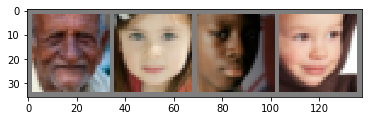

In [68]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_face_loader)
images, labels = dataiter.next()

# show images
out = torchvision.utils.make_grid(images)
imshow(out)

In [69]:
labels

tensor([92.,  6.,  9.,  3.], dtype=torch.float64)

In [70]:
from torchvision.models import mobilenet_v2
import torch.nn as nn
import torch.nn.functional as F

# Загрузить предобученную сеть -- pretrained=True
net = mobilenet_v2(pretrained=True)

In [91]:
net

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [72]:
for param in net.parameters():
    param.requires_grad = False

In [73]:
net.classifier[1] = nn.Linear(1280, 1)#requires_grad = True

In [88]:
#net.classifier[1] = nn.Sequential(nn.Linear(1280, 128), nn.Linear(128, 1))

In [48]:
#net.fs = nn.Linear(512, 1)#requires_grad = True

In [89]:
for parameter in net.parameters():
    print(parameter.data.shape)

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([16, 32, 1, 1])
torch.Size([16])
torch.Size([16])
torch.Size([96, 16, 1, 1])
torch.Size([96])
torch.Size([96])
torch.Size([96, 1, 3, 3])
torch.Size([96])
torch.Size([96])
torch.Size([24, 96, 1, 1])
torch.Size([24])
torch.Size([24])
torch.Size([144, 24, 1, 1])
torch.Size([144])
torch.Size([144])
torch.Size([144, 1, 3, 3])
torch.Size([144])
torch.Size([144])
torch.Size([24, 144, 1, 1])
torch.Size([24])
torch.Size([24])
torch.Size([144, 24, 1, 1])
torch.Size([144])
torch.Size([144])
torch.Size([144, 1, 3, 3])
torch.Size([144])
torch.Size([144])
torch.Size([32, 144, 1, 1])
torch.Size([32])
torch.Size([32])
torch.Size([192, 32, 1, 1])
torch.Size([192])
torch.Size([192])
torch.Size([192, 1, 3, 3])
torch.Size([192])
torch.Size([192])
torch.Size([32, 192, 1, 1])
torch.Size([32])
torch.Size([32])
torch.Size([192, 32, 1, 1])
torch.Size([192])
torch.Size([192])
torch.

In [90]:
net.classifier[1]

Sequential(
  (0): Linear(in_features=1280, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=1, bias=True)
)

In [92]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.classifier[1].parameters(), lr=0.000001, momentum=0.9)

In [93]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [94]:
device

device(type='cpu')

In [95]:
from torch.utils.tensorboard import SummaryWriter

## default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('./boards/tl2')

In [ ]:
train_cases = 0
test_cases = 0
best_metric = 9999
best_epoch = 0
PATH = './face_regr_back.pth'
for epoch in range(10):  # loop over the dataset multiple times
    train_mse=0
    train_mae=0
    train_cases = 0  
    valid_mse=0
    valid_mae=0
    test_cases = 0
    for i, data in enumerate(train_face_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        
        net.train()
        with torch.set_grad_enabled(True):
            inputs, labels = data
            inputs = inputs.float()
            labels = labels.float()
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.float())
            outputs = torch.reshape(outputs, (-1,))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            train_mse += loss.item()
            train_mae += sum(abs(list(outputs.detach().numpy())-labels.numpy()))
            train_cases += len(labels.numpy())
        if i % 200 == 199:    # print every 2000 mini-batches
            # ...log the running loss
            writer.add_scalar('training loss',
                            train_mse / train_cases,
                            epoch * len(train_face_loader) + i)
    for k, data in enumerate(valid_face_loader, 0):
        with torch.no_grad():
            images, labels = data
            net.eval()
            outputs = net(images)
            outputs = torch.reshape(outputs, (-1,))

            valid_mae += sum(abs(list(outputs.detach().numpy())-labels.numpy()))
            valid_mse += sum(np.square(list(outputs.detach().numpy())-labels.numpy()))
            test_cases += len(labels.numpy())
    print(f'Epoch # {epoch}:', 
          '\t', f'train_mae {round(train_mae/train_cases, 2)} ',f'valid_mae {round(valid_mae/test_cases, 2)}',
          '\t', f'train_mse {round(train_mse/train_cases, 2)} ',f'valid_mse {round(valid_mse/test_cases, 2)}')
    #callback best model
    if valid_mae/test_cases<best_metric:
        best_metric = valid_mae/test_cases
        best_epoch = epoch
        torch.save(net.state_dict(), PATH)
    
    # early stopping  
    if epoch - best_epoch>3:
        break
        
print('Finished Training')

Epoch # 0: 	 train_mae 20.91  valid_mae 22.01 	 train_mse 171.15  valid_mse 878.48
Epoch # 1: 	 train_mae 19.82  valid_mae 21.61 	 train_mse 146.47  valid_mse 858.14
Epoch # 2: 	 train_mae 19.62  valid_mae 20.26 	 train_mse 143.08  valid_mse 763.8
Epoch # 3: 	 train_mae 19.41  valid_mae 19.7 	 train_mse 141.56  valid_mse 724.12
Epoch # 4: 	 train_mae 19.27  valid_mae 19.76 	 train_mse 139.44  valid_mse 719.71
Epoch # 5: 	 train_mae 19.17  valid_mae 19.82 	 train_mse 137.15  valid_mse 730.61


In [ ]:
%tensorboard --logdir boards

In [26]:
writer.add_graph(net, images)
writer.close()

In [74]:
#uploading best model
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

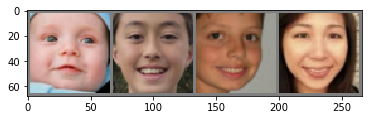

Predicted:  2.3515136 9.852959 8.384478 23.841509
Ground Truth:    1.0      14.0       8.0      28.0


In [75]:

dataiter = iter(test_face_loader)
images, labels = dataiter.next()
net.eval()
with torch.no_grad():
    outputs = net(images)
    outputs = torch.reshape(outputs, (-1,))
    # print images
    imshow(torchvision.utils.make_grid(images))
    print('Predicted: ', ' '.join('%3s' % str(list(outputs.detach().numpy())[j])
                                  for j in range(4)))
    print('Ground Truth: ', '     '.join('%5s' % str(labels.numpy()[j])
                                  for j in range(4)))

In [76]:
abs_errors = 0
square_error = 0
net.eval()
with torch.no_grad():
    for data in test_face_loader:
        images, labels = data
        outputs = net(images)
        outputs = torch.reshape(outputs, (-1,))
        
        abs_errors += sum(abs(list(outputs.detach().numpy())-labels.numpy()))
        square_error += sum(np.square(list(outputs.detach().numpy())-labels.numpy()))

In [77]:
print('MAE: %.2f' % (abs_errors / len(test)))
print('MSE: %.1f' % (square_error / len(test)))

MAE: 7.60
MSE: 134.3
